## Introduction ##

I am researching whether national suicide rates are correlated with economic opportunity, political freedom, and military presence, using the Gapminder dataset.  The variables I am using to measure these attributes are: Suicide Rate (per 100,000 population), Employment Rate, Armed Forces Rate (size of active military in proportion to population), and Polity Score.

### Chi Square Tests ###

Please see the chi square section under the discussion of each variable.


In [1]:
# Import packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

# Enable command results to be displayed in Jupyter notebook

%matplotlib inline

# Read in data

df = pd.read_csv('gapminder.csv',low_memory=False)

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Organizing Data ##

In [2]:
# View the first few rows of the dataframe

df.head(4)

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.65412162280064,48.673,,0,,6.68438529968262,55.7000007629394,24.04
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.9899469578783,76.918,,9,636.341383366604,7.69932985305786,51.4000015258789,46.72
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.5000733055148,73.131,.42009452521537,2,590.509814347428,4.8487696647644,50.5,65.22
3,Andorra,21943.3398976022,10.17,,,,,,81,,,,,5.36217880249023,,88.92


In [3]:
# Get Dimensions of DataFrame

# There are 213 Rows, 16 columns

print(len(df))
print(len(df.columns))

213
16


In [4]:
# Confirm current data type of column 

df['armedforcesrate'].dtype

dtype('O')

In [5]:
# Convert the variables I want to keep to numeric

numCols = ['suicideper100th','employrate','armedforcesrate','polityscore']

for i in numCols:
    df[i] = pd.to_numeric(df[i],errors='coerce')

In [6]:
# Confirm data type conversion - now Float

df['armedforcesrate'].dtype

dtype('float64')

In [7]:
# Subset columns

keepCols = ['country','suicideper100th','employrate','armedforcesrate','polityscore']

df2 = df[keepCols]

df2.head()

,country,suicideper100th,employrate,armedforcesrate,polityscore
0,Afghanistan,6.684385,55.700001,0.569653,0
1,Albania,7.699330,51.400002,1.024736,9
2,Algeria,4.848770,50.500000,2.306817,2
3,Andorra,5.362179,NaN,NaN,NaN
4,Angola,14.554677,75.699997,1.461329,-2


##### Handling Missing Data #####

I dropped any countries that were missing a value for any of my variables. 

This left 152 countries to analyze.

In [8]:
# Drop countries with no values for any explanatory variables

df2 = df2.dropna(subset=['suicideper100th','employrate','armedforcesrate','polityscore'],how='any')

print(len(df2))

152


## Univariate Analysis ##

### Suicide Rate - Response Variable ###

Most countries fall between 5 and 12 suicides per 100,000 population. I considered as outliers any country above 25 or below 1.5 per 100,000.  This distribution is unimodal and moderately right-skewed.

Four of the five countries with the lowest reported rates are in the Middle East.

Four of the seven countries with the highest rates are former Soviet republics (or in the case of Belarus, in the same region).

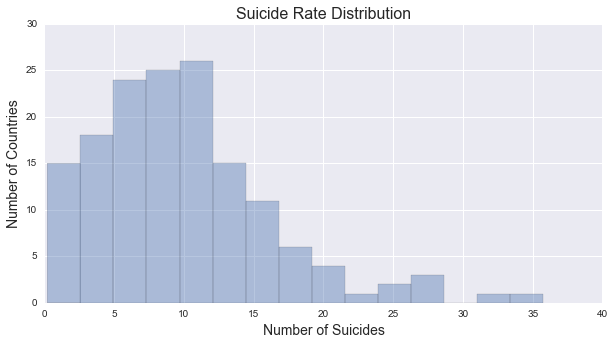

In [9]:
# Plot histogram to visualize distribution

# Suicides per 100K population

plt.figure(figsize=(10,5))
ax = sns.distplot(df2['suicideper100th'],kde=False)
plt.title('Suicide Rate Distribution',fontsize=16)
plt.xlabel('Number of Suicides',fontsize=14)
plt.ylabel('Number of Countries',fontsize=14)

In [10]:
# Identify Upper Extremes

df2.loc[(df2['suicideper100th']>=25),('country','suicideper100th')].sort_values(by='suicideper100th',ascending=False)

,country,suicideper100th
80,Guyana,35.752872
110,Lithuania,33.341860
180,Sri Lanka,28.104046
159,Russia,27.874160
16,Belarus,26.874690
103,Laos,26.219198
96,Kazakhstan,25.404600


In [11]:
# Identify Lower Extremes

df2.loc[(df2['suicideper100th']<=1.5),('country','suicideper100th')].sort_values(by='suicideper100th')

,country,suicideper100th
95,Jordan,0.201449
186,Syria,0.523528
11,Azerbaijan,1.380965
201,United Arab Emirates,1.392951
101,Kuwait,1.498057


#### Suicide Rate - Chi Square Test ####

In order to be able to run chi square tests, I classified the continuous quantitative values for suicide rate into two quantiles, split at the median value of approximately 8.94 per 100,000.

In [12]:
# Add column 

suicideMedian = df2['suicideper100th'].median()

print(suicideMedian)

8.943233251525879


In [13]:
# Reclassify into two bins - above and below median

df2['suicideratecat'] = pd.qcut(df2['suicideper100th'],q=2,labels=['0','1']) 


In [14]:
df2.head()

,country,suicideper100th,employrate,armedforcesrate,polityscore,suicideratecat
0,Afghanistan,6.684385,55.700001,0.569653,0,0
1,Albania,7.699330,51.400002,1.024736,9,0
2,Algeria,4.848770,50.500000,2.306817,2,0
4,Angola,14.554677,75.699997,1.461329,-2,1
6,Argentina,7.765584,58.400002,0.560987,8,0


### Employment Rate  ###

The distribution of employment rates centers around 60%, with a high in the 80s and a low in the 30s.  It's important to note that the age cutoff is 15, which means that full-time high school and university-level students count as a negative in this metric.  So many high-performing economies are actually in the middle.

African countries are found at the high end of the range, while Middle Eastern countries are at the low end.

Two countries remaining in the dataset did not have employment rates reported.


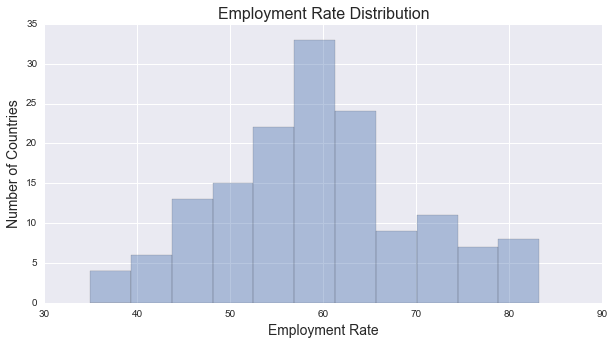

In [15]:
# Employment Rate Distribution

plt.figure(figsize=(10,5))
ax = sns.distplot(df2['employrate'],kde=False)
plt.title('Employment Rate Distribution',fontsize=16)
plt.xlabel('Employment Rate', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)

In [16]:
# Identify Upper Extremes

df2.loc[(df2['employrate']>=80),('country','employrate')].sort_values(by='employrate',ascending=False)


,country,employrate
29,Burundi,83.199997
199,Uganda,83.199997
114,Madagascar,83.000000
78,Guinea,81.500000
28,Burkina Faso,81.300003
60,Ethiopia,80.699997


In [17]:
# Identify lower Extremes

df2.loc[(df2['employrate']<=40),('country','employrate')].sort_values(by='employrate')


,country,employrate
113,"Macedonia, FYR",34.900002
89,Iraq,37.400002
95,Jordan,38.900002
210,"Yemen, Rep.",39.000000


#### Employment Rate Chi Square Test ####

I split the continuous quantitative values of employment rate values into five categorical quantiles, each representing approximately 20% of dataset, and assigned them to a new column in the dataframe.

I then created a crosstab to see how the number of countries within each employment rate quantile fell into the two suicide rate categories. 

The chi square test function took this crosstab as an input and compared the values in each cell to the counts that would have been expected if there was no correlation between employment rate and suicide rate. 

With a p-value of approximaely .249, the test shows that there is not enough evidence to reject the null hypothesis, which states that employment rate and suicide rate are not associated.  Because there was no correlation, a post hoc test was not necessary.


In [18]:
# Reclassify Employment Rate Into Quantiles

df2['employratequantiles'] = pd.qcut(df2['employrate'],labels=['Q1','Q2','Q3','Q4','Q5'],q=5)


In [19]:
df2.head()

,country,suicideper100th,employrate,armedforcesrate,polityscore,suicideratecat,employratequantiles
0,Afghanistan,6.684385,55.700001,0.569653,0,0,Q2
1,Albania,7.699330,51.400002,1.024736,9,0,Q2
2,Algeria,4.848770,50.500000,2.306817,2,0,Q1
4,Angola,14.554677,75.699997,1.461329,-2,1,Q5
6,Argentina,7.765584,58.400002,0.560987,8,0,Q3


In [20]:
# Create crosstab - See Number of Countries in Each Suicide Rate Bin

ctemp = pd.crosstab(df2['suicideratecat'],df2['employratequantiles'])

print(ctemp)

employratequantiles  Q1  Q2  Q3  Q4  Q5
suicideratecat                         
0                    20  13  17  14  12
1                    11  17  13  16  19


In [21]:
# Conduct Chi Square Test

csemp = scipy.stats.chi2_contingency(ctemp)

print(csemp)

(5.3935483870967733, 0.24924633016655007, 4, array([[ 15.5,  15. ,  15. ,  15. ,  15.5],
       [ 15.5,  15. ,  15. ,  15. ,  15.5]]))


### Armed Forces Rate ###

The vast majority of countries had armed forces rates of less than 1% of population.  This distribution is heavily right-skewed.

Outliers on the high side (above 6%) are North Korea, Eritrea, Iraq, and Singapore. 

On the low end are Haiti (which disbanded its military in 1995) and a number of African countries..

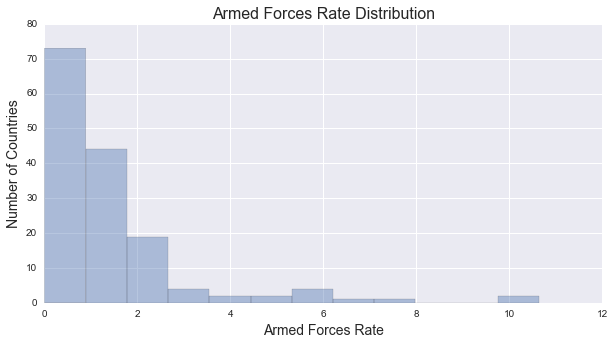

In [22]:
# Visualize distribution with histogram

plt.figure(figsize=(10,5))
ax = sns.distplot(df2['armedforcesrate'],kde=False,bins=12)
plt.title('Armed Forces Rate Distribution',fontsize=16)
plt.xlabel('Armed Forces Rate', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)

In [23]:
# Identify higher outliers

df2.loc[(df2['armedforcesrate']>=6.0),('country','armedforcesrate')].sort_values(by='armedforcesrate',ascending=False)

,country,armedforcesrate
99,"Korea, Dem. Rep.",10.638521
58,Eritrea,9.820127
89,Iraq,7.737913
173,Singapore,6.394936


In [24]:
# Identify lower outliers

df2.loc[(df2['armedforcesrate']<=0.15),('country','armedforcesrate')].sort_values(by='armedforcesrate')

,country,armedforcesrate
81,Haiti,0.000000
131,Mozambique,0.102269
149,Papua New Guinea,0.105115
115,Malawi,0.114592
107,Liberia,0.129953
70,Ghana,0.131487
67,Gambia,0.134591
189,Tanzania,0.134730
35,Central African Rep.,0.148659


#### Armed Forces Rate Chi Square Test ####

I split the continuous quantitative values of armed forces rate values into 3 categorical bins, and assigned them to a new column in the dataframe.  Each bin is therefore two percentage points of population.  It was necessary to consolidate into fewer bins in order to avoid creating any bins with expected values of zero for both suicide rate categories.

I then created a crosstab to see how the number of countries within each armed forces rate bin fell into the two suicide rate categories.

The chi square test function took this crosstab as an input and compared the values in each cell to the counts that would have been expected if there was no correlation between suicide rate and armed forces rate.

With a p-value of approximaely .197, the test shows that there is not enough evidence to reject the null hypothesis, which states that armed forces rate and suicide rate are not associated.  Therefore, a post hoc test was not necessary.

In [25]:
bins=[0,4,8,12]

df2['armedforcescat'] = pd.cut(df2['armedforcesrate'],bins)

In [26]:
# Create crosstab 

ctarm = pd.crosstab(df2['suicideratecat'],df2['armedforcescat'])

print(ctarm)

armedforcescat  (0, 4]  (4, 8]  (8, 12]
suicideratecat                         
0                   67       6        2
1                   73       3        0


In [27]:
# Conduct Chi Square Test

csarm = scipy.stats.chi2_contingency(ctarm)

print(csarm)

(3.250662907268171, 0.19684641892916596, 2, array([[ 69.53642384,   4.47019868,   0.99337748],
       [ 70.46357616,   4.52980132,   1.00662252]]))


### Polity Scores ###

GapMinder classified each country's political freedom on a scale of -10 (autocracy) to +10 (democracy).  For more details, see the <a href="http://www.systemicpeace.org/polityproject.html" target="_blank">Polity IV Project</a> website.

Thirty-two countries were given the highest possible score, including much of Europe and North America, while 46 countries received negative scores.  This distribution is heavily left-skewed.

Countries with low scores are not limited to a particular geographic region. 

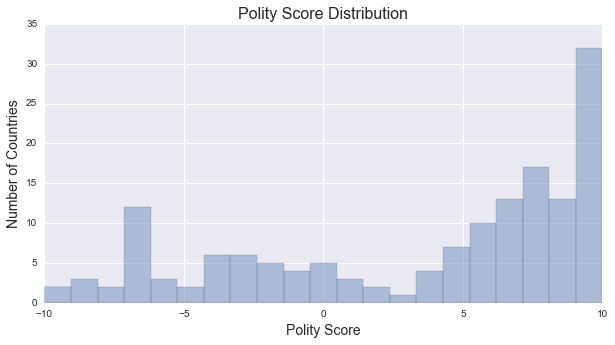

In [28]:
# Polity Score distribution

plt.figure(figsize=(10,5))
ax = sns.distplot(df2['polityscore'],bins=21,kde=False)
plt.title('Polity Score Distribution',fontsize=16)
plt.xlabel('Polity Score',fontsize=14)
plt.ylabel('Number of Countries',fontsize=14)

In [29]:
# Count scores less than zero

df2.loc[df2['polityscore']<0,['country']].count()

country    45
dtype: int64

In [30]:
# Highest-ranking countries

df2.loc[(df2['polityscore']>=9.1),('country','polityscore')].sort_values(by='country',ascending=True)

,country,polityscore
9,Australia,10
10,Austria,10
32,Canada,10
37,Chile,10
44,Costa Rica,10
48,Cyprus,10
50,Denmark,10
63,Finland,10
69,Germany,10
72,Greece,10


In [31]:
# Identify lower outliers

df2.loc[(df2['polityscore']<=-7),('country','polityscore')].sort_values(by=['polityscore','country'],ascending=True)

,country,polityscore
156,Qatar,-10
167,Saudi Arabia,-10
99,"Korea, Dem. Rep.",-9
197,Turkmenistan,-9
205,Uzbekistan,-9
145,Oman,-8
201,United Arab Emirates,-8
11,Azerbaijan,-7
13,Bahrain,-7
16,Belarus,-7


#### Polity Score Chi Square Test ####


I reclassified the polity score values into 4 categorical bins, and assigned them to a new column in the dataframe. Each bin now covers five points on the scale of -10 to +10. 

I then created a crosstab to see how the number of countries within polity score bin fell into the two suicide rate categories.

The chi square test function took this crosstab as an input and compared the values in each cell to the counts that would have been expected if there was no correlation between suicide rate and polity score.

With a p-value of approximately 0.489, the test shows that there is nowhere near enough evidence to reject the null hypothesis, which states that polity score and suicide rate are not associated.  Because there is no correlation, a post hoc test is not required.

In [32]:
# Reclassify

polbins=[-10,-5,0,5,10]

df2['polityscorecat'] = pd.cut(df2['polityscore'],polbins)


In [33]:
# Create crosstab 

ctpol = pd.crosstab(df2['suicideratecat'],df2['polityscorecat'])

print(ctpol)

polityscorecat  (-10, -5]  (-5, 0]  (0, 5]  (5, 10]
suicideratecat                                     
0                      13       15       7       39
1                       9       11      10       46


In [34]:
# Conduct Chi Square Test

cspol = scipy.stats.chi2_contingency(ctpol)

print(cspol)

(2.4223036606937534, 0.48949630791446663, 3, array([[ 10.85333333,  12.82666667,   8.38666667,  41.93333333],
       [ 11.14666667,  13.17333333,   8.61333333,  43.06666667]]))
